# Imports

In [3]:
# Data Wrangling and Loading
import pandas as pd
import numpy as np
import sqlite3

# Common 
import os
from pathlib import Path

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Modeling
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [36]:
# Seabron style and context
sns.set_style("whitegrid", {'axes.labelcolor': "b", 'axes.edgecolor': 'r', 'xtick.color': 'g'})
sns.set_context('notebook');

# Data

## Data description

The dataset is provided by MegaFon at the MegaFon Uplift Competition hosted in may 2021.

The dataset contains generated synthetic data, trying to bring them closer to the real case that they encountered.

**Fields**

X_1…X_50: anonymized feature set
treatment_group (str): treatment/control group flag
conversion (binary): customer purchasing

**Key figures**

Format: CSV
Size: 554M
Rows: 600,000
Response Ratio: .2
Treatment Ratio: .5

## Read data and process

- All data stored in SQLite DataBase. 
- Data fetching stage was refactored to ```src/data/make_dataset.py```
- Data transformation stage was refactored to ```src/features/transformation.py```
- Feature engineering stage was refactored to ```src/features/build_features.py```

In [5]:
# Read transformed dataset

db_url = os.environ["DATABASE_URL"] 
with sqlite3.connect(f'../{db_url}') as conn:
    query = 'SELECT * FROM megafon_interim'
    data = pd.read_sql(query, conn)

print(data.info(verbose=False))
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 52 entries, X_1 to conversion
dtypes: float64(50), int64(2)
memory usage: 238.0 MB
None


,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_group,conversion
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0,0
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0,0
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,1,0
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,1,0
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,1,0


Split columns to different categories:
1. Target:
2. Treatment:
3. Modeling features.

In [6]:
target = 'conversion'
treatment = 'treatment_group'
not_features = [target, treatment]
features = data.columns.difference(not_features).to_list()

# Sort features because sqlite returns columns at random order
features = sorted(features, key=lambda x: int(x.lstrip('X_')))

assert len(not_features + features) == len(data.columns), 'sanity check'

Lets look at datatype of features.

In [9]:
mapper = {**dict.fromkeys(features, 'feature'), **dict.fromkeys(not_features, 'not_feature')}
feature_dtypes = data.dtypes
feature_dtypes.index = feature_dtypes.index.map(mapper)
feature_dtypes = feature_dtypes.reset_index().set_axis(['attrubute_type', 'data_type'], axis=1)
feature_dtypes.value_counts().to_frame('features count')

,,features count
attrubute_type,data_type,
feature,float64,50
not_feature,int64,2


There are only numerical features in dataset that are anonymised, probably using method like PCA.

# Exploratory Data Analysis

Goals:

1. Explore relationship between target and treatment features;
2. Explore features (descriptive statistics, relationship);
3. Explore dependencies between target and features (correlations and etc).

## Target and Treatment features Analysis

### Target share for Treatment/Control groups.

In [10]:
normalize_opt = [False, 'all', 'columns', 'index']
freq_tables = [
    pd.crosstab(data[target], data[treatment], margins=True, normalize=opt).round(2)
    for opt in normalize_opt
    ]

display(*freq_tables)

treatment_group,0,1,All
conversion,,,
0,245878,231608,477486
1,53754,68760,122514
All,299632,300368,600000


treatment_group,0,1,All
conversion,,,
0,0.41,0.39,0.8
1,0.09,0.11,0.2
All,0.50,0.50,1.0


treatment_group,0,1,All
conversion,,,
0,0.82,0.77,0.8
1,0.18,0.23,0.2


treatment_group,0,1
conversion,,
0,0.51,0.49
1,0.44,0.56
All,0.50,0.50


- There are target class imbalance;
- Treatment and Control group sizes are same.

### Conditional Independence Assumption

Lets check that treatment and control group splitted at random using Adversal Validation method.

In [34]:
clf = LogisticRegression(C=1, n_jobs=-1, random_state=2022, solver='saga', max_iter=10_000)
cv_scores = cross_val_score(
    clf, 
    data[features], data[treatment], 
    scoring='roc_auc', cv=3
    )

cv_scores = cv_scores.mean()
print(f'Adversal Validaton Roc Auc: {cv_scores:.2%}')

Adversal Validaton Roc Auc: 49.91%


### Time dependence 

Lets check that log_loss is equal on all data folds.

In [83]:
clf = LogisticRegression(C=1, n_jobs=-1, random_state=2022, solver='saga', max_iter=10_000)
cv_scores = cross_val_score(
    clf, 
    data[features], data[treatment], 
    scoring='neg_log_loss', cv=10
    )

In [ ]:
plot_df = pd.Series(cv_scores).add_prefix('Fold #')
ax = sns.barplot(x=plot_df.index, y=plot_df)
ax.set_title('LogLoss vs # Fold')
ax.set_xlabel('# Fold')
ax.set_ylabel('LogLoss');

Based on features classifier cannot distinguish between treatment and control groups. That means that communication was carried out by random.

## Feature Analysis

### Check for null values

In [12]:
null_values_freq = (
    data[features].isna().sum().to_frame('num_null')
    .assign(perc_null=lambda x: x['num_null']/len(data))
    .mean()
)
null_values_freq.to_frame('value')

,value
num_null,0.0
perc_null,0.0


Dataset contains no null values.

### Descriptive statistics

In [44]:
def compute_stats(df):

    stats_df = df.describe(percentiles=[.5]).T.drop(columns=['count'])
    extra_stats = [
        data.skew().to_frame('skewness'), data.kurtosis().to_frame('kurtosis'),
        (data - data.mean()).abs().mean().to_frame('mad')
        ]
    stats_df = stats_df.join(extra_stats)

    # Prettificaiton
    stats_df = stats_df.rename(columns={'50%': 'median'})
    col_order = ['min', 'max', 'mean', 'median', 'std', 'mad', 'skewness', 'kurtosis']
    return stats_df[col_order]


descriptive_stats = data[features].pipe(compute_stats)

Check if there some logical ordering in feature names. For example some consequent features form a group like revenue for 1/3/6/12 months from report date.

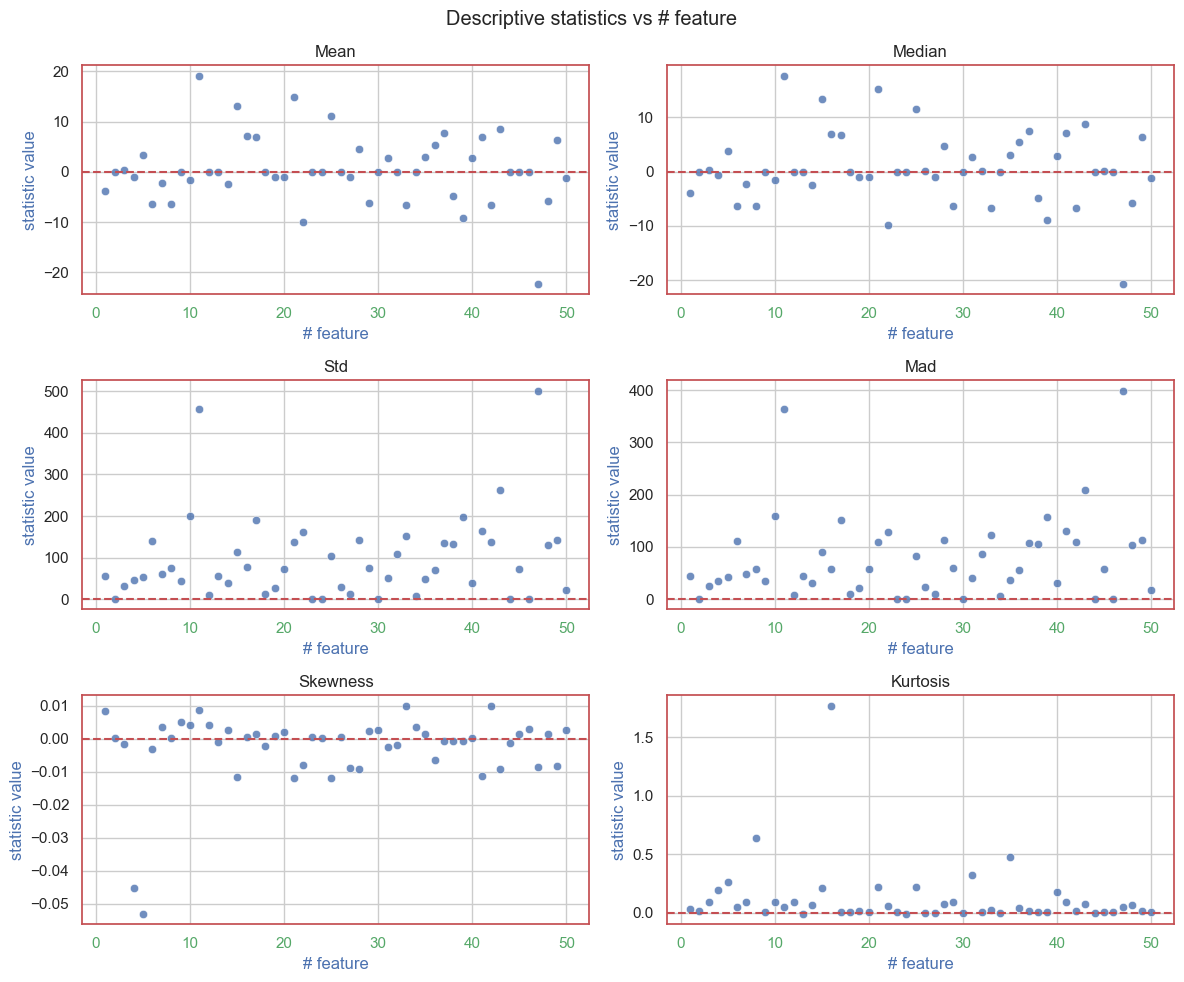

In [69]:
plot_cols = ['mean', 'median', 'std', 'mad', 'skewness', 'kurtosis']
plot_df = descriptive_stats[plot_cols].copy()
plot_df.index = plot_df.index.str.lstrip('X_').astype('int')
spec = np.arange(len(plot_cols)).reshape(3, 2)

fig = plt.figure(figsize=(12, 10))
plt.suptitle('Descriptive statistics vs # feature')
gs = fig.add_gridspec(3, 2)
for i, stat_name in enumerate(plot_cols):
    
    row, col = np.where(spec == i)
    ax = fig.add_subplot(gs[row[0], col[0]])
    ax.set_title(stat_name.capitalize())
    ax.set_xlabel('# feature')
    ax.set_ylabel('statistic value')
    sns.scatterplot(x=plot_df.index, y=plot_df[stat_name], alpha=0.8, ax=ax)
    plt.axhline(0, color='r', linestyle='--')
plt.tight_layout();

Check if there some logical ordering in descriptive stats.

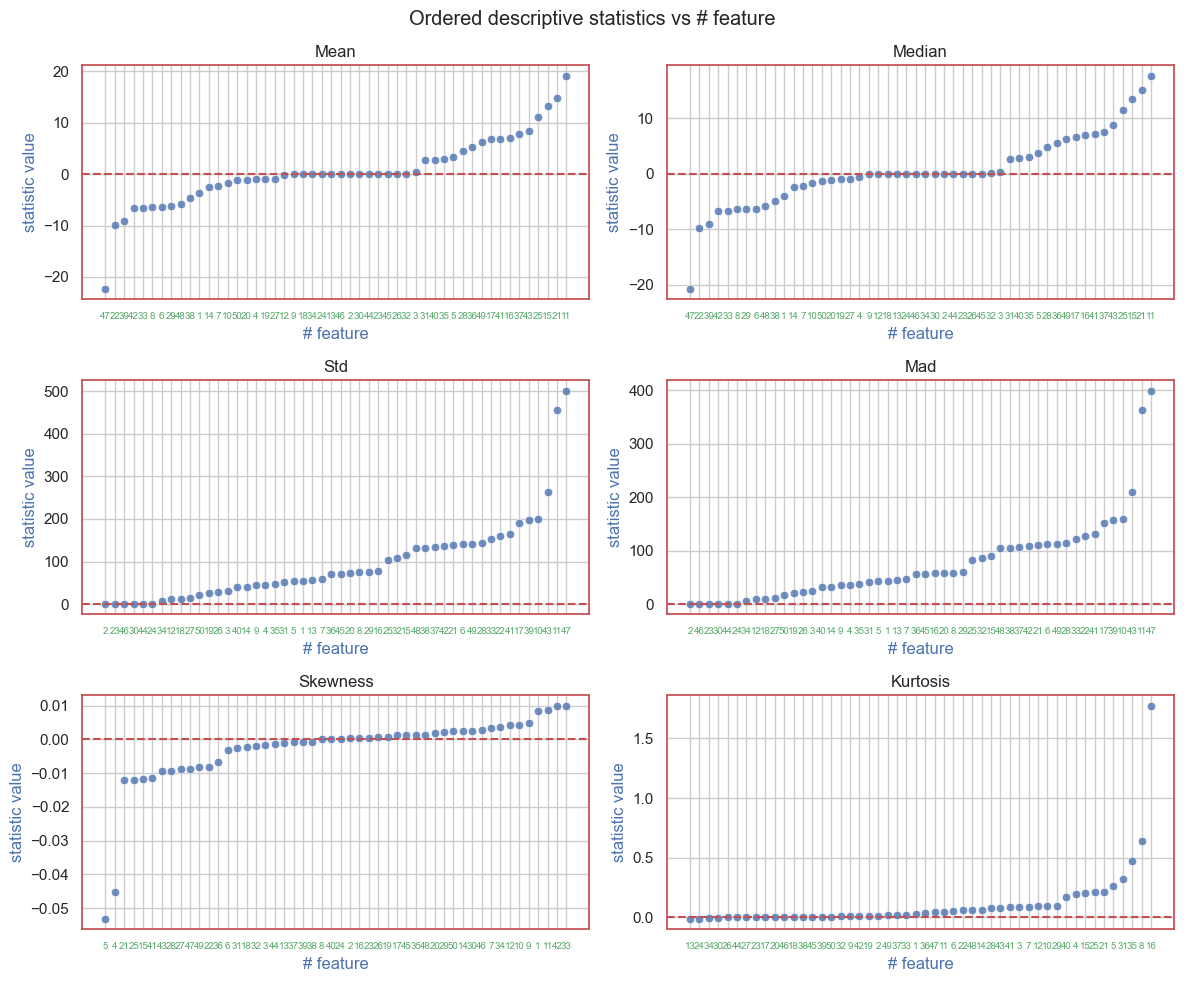

In [80]:
plot_cols = ['mean', 'median', 'std', 'mad', 'skewness', 'kurtosis']
plot_df = descriptive_stats[plot_cols].copy()
plot_df.index = plot_df.index.str.lstrip('X_').astype('object')
spec = np.arange(len(plot_cols)).reshape(3, 2)

fig = plt.figure(figsize=(12, 10))
plt.suptitle('Ordered descriptive statistics vs # feature')
gs = fig.add_gridspec(3, 2)
for i, stat_name in enumerate(plot_cols):
    
    row, col = np.where(spec == i)
    ax = fig.add_subplot(gs[row[0], col[0]])
    ax.set_title(stat_name.capitalize())
    ax.set_xlabel('# feature')
    plt.xticks(fontsize=7)
    ax.set_ylabel('statistic value')
    plot_df = plot_df.sort_values(stat_name)
    sns.scatterplot(x=plot_df.index, y=plot_df[stat_name], alpha=0.8, ax=ax)
    plt.axhline(0, color='r', linestyle='--')
plt.tight_layout();

# Validation Schema

In [60]:
df[treatment] = df[treatment].eq('treatment').astype('int')

In [61]:
train_idx, test_idx = train_test_split(df.index, test_size=0.2, stratify=df[[target, treatment]], random_state=2022)

X_train, y_train, treatment_train = df.loc[train_idx, features], df.loc[train_idx, target], df.loc[train_idx, treatment] 
X_test, y_test, treatment_test = df.loc[test_idx, features], df.loc[test_idx, target], df.loc[test_idx, treatment]

# Modeling

In [62]:
rf_model = RandomForestClassifier(max_depth=8, min_samples_leaf=124, random_state=2022)
ct_model = ClassTransformation(rf_model)

In [63]:
ct_model.fit(X_train, y_train, treatment_train)

ClassTransformation(estimator=RandomForestClassifier(max_depth=8,
                                                     min_samples_leaf=124,
                                                     random_state=2022))

# Evaluation

In [99]:
y_uplift_pred = ct_model.predict(X_test)

uplift_table = uplift_by_percentile(y_test, y_uplift_pred, treatment_test, bins=10, total=True)
uplift_table

/Users/alexwest/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,6081,5919,0.416708,0.162190,0.254518
10-20,5960,6040,0.285906,0.163576,0.122330
20-30,5993,6007,0.282997,0.174963,0.108034
30-40,6048,5952,0.279101,0.164147,0.114954
40-50,5957,6043,0.257009,0.154063,0.102946
50-60,6042,5958,0.208540,0.150386,0.058154
60-70,5944,6056,0.180855,0.163970,0.016885
70-80,6018,5982,0.183283,0.204948,-0.021665
80-90,5999,6001,0.129188,0.238460,-0.109272


In [83]:
quantiles = pd.qcut(y_uplift_pred, 10)
y_pred_df = pd.concat([y_test.to_frame(), treatment_test.to_frame()], axis=1)
y_pred_df['quantiles'] = quantiles

In [92]:
y_pred_df.pivot_table(index='quantiles', columns='treatment_group', values='conversion')

treatment_group,0,1
quantiles,,
"(-0.229, -0.0121]",0.217493,0.063992
"(-0.0121, 0.0288]",0.238460,0.129188
"(0.0288, 0.0378]",0.204948,0.183283
"(0.0378, 0.0416]",0.163970,0.180855
"(0.0416, 0.046]",0.150386,0.208540
"(0.046, 0.0535]",0.154063,0.257009
"(0.0535, 0.0657]",0.164147,0.279101
"(0.0657, 0.0797]",0.174963,0.282997
"(0.0797, 0.0977]",0.163576,0.285906


In [98]:
np.quantile(y_uplift_pred, 0.1)

-0.012146129649857248